# GEE Time Series Data Retrieval

In [1]:
import geopandas as gpd
import ee
import geemap.foliumap  as geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_1764\1950953793.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
ee.Authenticate()

Enter verification code:  4/1AbUR2VO5n-bIUGUK9duVfqaKmbid4lOGHkTyHmrkY6Sjyxp27R_ibKoXmkY



Successfully saved authorization token.


In [3]:
ee.Initialize()

## Set up the environment

In [4]:
if 'data' not in os.listdir():
    os.mkdir('data')
    
if 'output' not in os.listdir():
    os.mkdir('output')
    
if 'TS' not in os.listdir('output'):
    os.mkdir('output/TS')

## Cities dataset retrieval and filtering

In [133]:
if 'cities.geojson' not in os.listdir('data'):
    # Read the dataset from url
    cities = gpd.read_file('https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000@public/exports/geojson?lang=en&timezone=Europe%2FBerlin')
    
    # Filter cities in Latin America with more than 2.5 million inhabitants
    cities = cities[(cities['cou_name_en'] == 'Colombia') & (cities['population'] >= 0.7e6) & (cities.bounds['miny'] < 20)]
    
    cities.to_file('data/cities.geojson', driver = 'GeoJSON')
else:
    # Read dataset directly from path
    cities = gpd.read_file('data/cities.geojson')

0    10.96854
1    10.39972
2     6.25184
3     7.89391
4     3.43722
5     4.60971
Name: geometry, dtype: float64

## Studied cities visualization

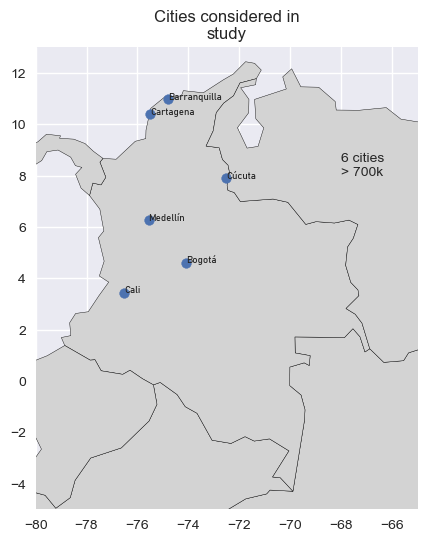

In [220]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.geometry.plot(color = 'lightgrey', edgecolor = 'k')

cities.plot(ax= ax)

for i in range(len(cities)):
    x = cities.geometry.apply(lambda df : float(str(df).split(' ')[1].split('(')[1])).iloc[i]
    y = cities.geometry.apply(lambda df : float(str(df).split(' ')[2].split(')')[0])).iloc[i]
    
    plt.text(x,y, cities.name.iloc[i], fontfamily = 'bahnschrift', fontsize = 7)
    
plt.text(x = -68, y = 8, s = str(len(cities)) + ' cities\n> 700k')

plt.xlim((-80,-65))
plt.ylim((-5,13))


plt.title('Cities considered in\nstudy')

fig = plt.gcf()

fig.set_figheight(6)
fig.set_figwidth(5)

fig.savefig('Studied_cities.png')

In [7]:
# Get coordinates from all 12 cities
coords = cities.bounds.iloc[:,:2]
coords.columns = ['Longitude', 'Latitude']

city_names = cities['name'].values

## Time Series Data Retrieval from GEE

In [221]:
# Download the 12 Time Series from Google Earth Engine

# Set dates and point of interest for filtering data
start_date = '2020-01-01'
end_date = '2020-12-31'

for i in range(len(coords)):
    
    poi = ee.Geometry.Point(tuple(coords.iloc[i].values));

    # Get image collections
    S_5P_NO2 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(poi).filterDate(start_date, end_date).select('tropospheric_NO2_column_number_density')
    S_5P_SO2 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').filterBounds(poi).filterDate(start_date, end_date).select('SO2_column_number_density')
    S_5P_PM = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_AER_AI').filterBounds(poi).filterDate(start_date, end_date).select('absorbing_aerosol_index')
    
        
    def get_TimeSeries(img_col, poi):
        S5_u_poi = img_col.getRegion(poi, scale = 10000).getInfo()

        TS = pd.DataFrame(S5_u_poi[1:]).dropna()
        TS.columns = S5_u_poi[0]
        TS['value'] = TS.iloc[:,4]
        TS['Date'] = TS['id'].apply(lambda df : pd.to_datetime(df[:15], format = '%Y%m%dT%H%M%S'))

        TS = TS[['Date','value']]

        return TS

    TS_N = get_TimeSeries(S_5P_NO2, poi)
    TS_S = get_TimeSeries(S_5P_SO2, poi)
    TS_PM =  get_TimeSeries(S_5P_PM, poi)
    
    # Export timeseries as csv files
    TS_N.to_csv('output/TS/'+city_names[i]+'_NO2_TimeSeries_2020.csv')
    TS_S.to_csv('output/TS/'+city_names[i]+'_SO2_TimeSeries_2020.csv')
    TS_PM.to_csv('output/TS/'+city_names[i]+'_AER_TimeSeries_2020.csv')

## Bi-Temporal Analysis for NO2

In [9]:
dates_2019 = ['2019-03-25', '2019-06-30']

dates_2020 = ['2020-03-25', '2020-06-30']

dates_2021 = ['2021-03-25', '2021-06-30']

Study_Cities = ee.Geometry.MultiPoint(coords = list(coords.apply(lambda df: [df.iloc[0], df.iloc[1]], axis = 1)))

S_5P_2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(Study_Cities).filterDate(dates_2019[0], dates_2019[1]).select('tropospheric_NO2_column_number_density').mean().clip(Study_Cities.buffer(10000))
S_5P_2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(Study_Cities).filterDate(dates_2020[0], dates_2020[1]).select('tropospheric_NO2_column_number_density').mean().clip(Study_Cities.buffer(10000))
S_5P_2021 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').filterBounds(Study_Cities).filterDate(dates_2021[0], dates_2021[1]).select('tropospheric_NO2_column_number_density').mean().clip(Study_Cities.buffer(10000))

Map = geemap.Map()

vis = {'min': 0,
       'max': 0.00015,
       'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

Map.addLayer(S_5P_2019, vis,'NO2 2019')
Map.addLayer(S_5P_2020, vis,'NO2 2020')
Map.addLayer(S_5P_2021, vis,'NO2 2021')

Map.centerObject(Study_Cities, zoom = 7)
Map.addLayer(Study_Cities, name = 'cities')

Map

In [41]:
geemap.ee_export_image(S_5P_2019, filename='S5_2019_NO2.tif', scale=1000, file_per_band=False)
geemap.ee_export_image(S_5P_2020, filename='S5_2020_NO2.tif', scale=1000, file_per_band=False)
geemap.ee_export_image(S_5P_2021, filename='S5_2021_NO2.tif', scale=1000, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\mdomi\Dropbox\MSc_WUR\5thPeriod\Advanced Earth Observation\AQ_Sent5_TS_Analysis_LAC\S5_2019_NO2.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\mdomi\Dropbox\MSc_WUR\5thPeriod\Advanced Earth Observation\AQ_Sent5_TS_Analysis_LAC\S5_2020_NO2.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\mdomi\Dropbox\MSc_WUR\5thPeriod\Advanced Earth Observation\AQ_Sent5_TS_Analysis_LAC\S5_2021_NO2.tif


In [40]:
geemap.ee_export_vector(ee.FeatureCollection(Study_Cities.buffer(10000)), 'StudiedArea.geojson')

Generating URL ...
Please wait ...
Data downloaded to C:\Users\mdomi\Dropbox\MSc_WUR\5thPeriod\Advanced Earth Observation\AQ_Sent5_TS_Analysis_LAC\StudiedArea.geojson


In [13]:
Map.to_html(filename='output/NO2_AQ_Colombia.html', title='NO2_Colombia', width='100%', height='880px')

In [119]:
S_5P_S_2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').filterBounds(Study_Cities).filterDate(dates_2019[0], dates_2019[1]).select('SO2_column_number_density').mean().clip(Study_Cities.buffer(10000))
S_5P_S_2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').filterBounds(Study_Cities).filterDate(dates_2020[0], dates_2020[1]).select('SO2_column_number_density').mean().clip(Study_Cities.buffer(10000))
S_5P_S_2021 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').filterBounds(Study_Cities).filterDate(dates_2021[0], dates_2021[1]).select('SO2_column_number_density').mean().clip(Study_Cities.buffer(10000))

In [134]:
def get_stats(image, year, contaminant):
    NO2_mean = []
    NO2_std = []

    for i in range(len(cities)):
        NO2_mean.append(list(image.reduceRegion(reducer = ee.Reducer.mean(), 
                                           scale = 1000,
                                           geometry = ee.Geometry.Point(Study_Cities.coordinates().get(i)).buffer(10000)).getInfo().values())[0])

        NO2_std.append(list(image.reduceRegion(reducer = ee.Reducer.stdDev(), 
                                               scale = 1000,
                                               geometry = ee.Geometry.Point(Study_Cities.coordinates().get(i)).buffer(10000)).getInfo().values())[0])

    
    cities[contaminant + '_'+year+'_mean'] = NO2_mean
    cities[contaminant + '_'+year+'_std'] = NO2_std    
    
    return cities

get_stats(S_5P_2019, '2019', 'NO2')
get_stats(S_5P_2020, '2020', 'NO2')
get_stats(S_5P_2021, '2021', 'NO2')

get_stats(S_5P_S_2019, '2019', 'SO2')
get_stats(S_5P_S_2020, '2020', 'SO2')
get_stats(S_5P_S_2021, '2021', 'SO2')

,geoname_id,name,ascii_name,feature_class,feature_code,country_code,cou_name_en,country_code_2,admin1_code,admin2_code,...,NO2_2020_mean,NO2_2020_std,NO2_2021_mean,NO2_2021_std,SO2_2019_mean,SO2_2019_std,SO2_2020_mean,SO2_2020_std,SO2_2021_mean,SO2_2021_std
0,3689147,Barranquilla,Barranquilla,P,PPLA,CO,Colombia,None,04,08001,...,0.000027,0.000004,0.000027,0.000007,-0.000033,0.000027,-0.000020,0.000034,5.540150e-07,0.000039
1,3687238,Cartagena,Cartagena,P,PPLA,CO,Colombia,None,35,13001,...,0.000026,0.000003,0.000027,0.000004,-0.000033,0.000025,-0.000065,0.000028,-3.305752e-05,0.000036
2,3674962,Medellín,Medellin,P,PPLA,CO,Colombia,None,02,05001,...,0.000020,0.000009,0.000028,0.000013,0.000062,0.000068,0.000029,0.000048,9.873876e-05,0.000097
3,3685533,Cúcuta,Cucuta,P,PPLA,CO,Colombia,None,21,54001,...,0.000017,0.000003,0.000015,0.000003,-0.000029,0.000021,-0.000016,0.000039,5.607858e-05,0.000045
4,3687925,Cali,Cali,P,PPLA,CO,Colombia,None,29,76001,...,0.000026,0.000006,0.000029,0.000007,0.000017,0.000049,0.000039,0.000039,3.188067e-05,0.000057
5,3688689,Bogotá,Bogota,P,PPLC,CO,Colombia,None,34,11001,...,0.000019,0.000012,0.000038,0.000029,0.000018,0.000051,-0.000040,0.000063,9.235879e-05,0.000071


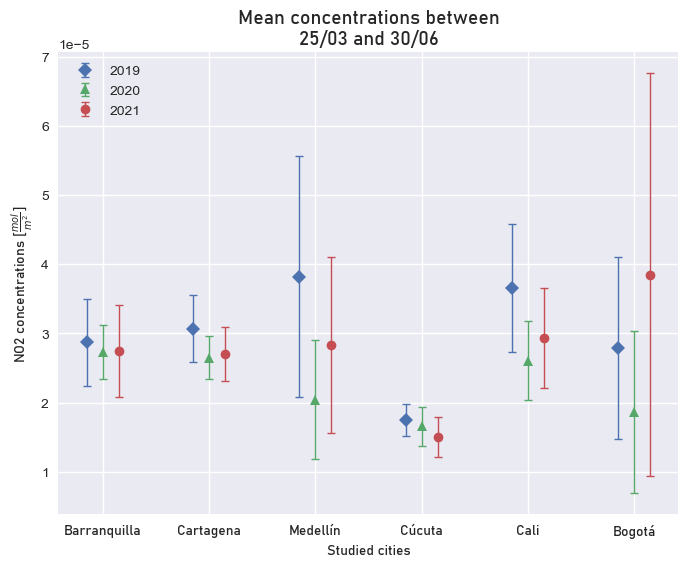

In [198]:
fig = plt.figure(figsize = (8,6))

plt.errorbar(np.arange(0,6,1)-0.15, cities['NO2_2019_mean'], yerr = cities['NO2_2019_std'], fmt = 'D', elinewidth = 1, capthick = 1, capsize = 3, label = '2019')
plt.errorbar(np.arange(0,6,1), cities['NO2_2020_mean'], yerr = cities['NO2_2020_std'], fmt = '^',  elinewidth = 1, capthick = 1, capsize = 3, label = '2020')
plt.errorbar(np.arange(0,6,1)+0.15, cities['NO2_2021_mean'], yerr = cities['NO2_2021_std'], fmt = 'o',  elinewidth = 1, capthick = 1, capsize = 3, label = '2021')
plt.legend(loc = 2)
plt.xticks(np.arange(0,6,1), cities.name, fontdict={'family':'bahnschrift'})
plt.xlabel('Studied cities', fontdict={'family':'bahnschrift'})
plt.ylabel('NO2 concentrations $[\\frac{mol}{m^2}]$', fontdict={'family':'bahnschrift'})

plt.title('Mean concentrations between\n25/03 and 30/06', fontdict={'family':'bahnschrift'}, fontsize=14)

fig.savefig('BiTemporal_Analyisis_NO2.png', dpi = 130)

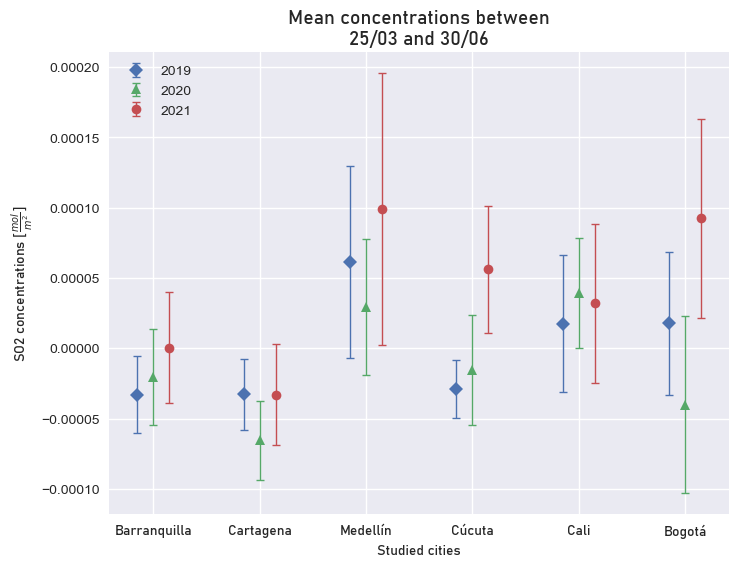

In [199]:
fig = plt.figure(figsize = (8,6))

plt.errorbar(np.arange(0,6,1)-0.15, cities['SO2_2019_mean'], yerr = cities['SO2_2019_std'], fmt = 'D', elinewidth = 1, capthick = 1, capsize = 3, label = '2019')
plt.errorbar(np.arange(0,6,1), cities['SO2_2020_mean'], yerr = cities['SO2_2020_std'], fmt = '^',  elinewidth = 1, capthick = 1, capsize = 3, label = '2020')
plt.errorbar(np.arange(0,6,1)+0.15, cities['SO2_2021_mean'], yerr = cities['SO2_2021_std'], fmt = 'o',  elinewidth = 1, capthick = 1, capsize = 3, label = '2021')
plt.legend(loc = 2)
plt.xticks(np.arange(0,6,1), cities.name, fontdict={'family':'bahnschrift'})
plt.xlabel('Studied cities', fontdict={'family':'bahnschrift'})
plt.ylabel('SO2 concentrations $[\\frac{mol}{m^2}]$', fontdict={'family':'bahnschrift'})

plt.title('Mean concentrations between\n25/03 and 30/06', fontdict={'family':'bahnschrift'}, fontsize=14)

fig.savefig('BiTemporal_Analyisis_SO2.png', dpi = 130)